# Neural ODEs
# Exercise 1: Implementing ODE solvers
In the first part of this exercise, we will familiarize ourselves with ODEs by implementing our own solvers in NumPy.

## Toy-problem: Lotka-Volterra
For the purpose of this exercise, we are simulate the non-linear, time invariant *"predator–prey equations"*.

> The Lotka–Volterra equations, also known as the predator–prey equations, are a pair of first-order nonlinear differential equations, frequently used to describe the dynamics of biological systems in which two species interact, one as a predator and the other as prey.

They are defined as 

\begin{align*}
\frac{\partial u_1}{\partial t} &= \alpha u_1 - \beta u_1 u_2\\
\frac{\partial u_2}{\partial t} &= \gamma u_1 u_2 - \delta u_2
\end{align*}

where $u_1$ is the population of prey (e.g. rabbits) and $u_2$ the population of predators (e.g. foxes) in thousands.

For this first exercise, we are going to assume that the dynamics are fully known
with parameters 

$$\alpha=1.5,\, \beta=1,\, \gamma=3,\, \delta=1$$

and the initial condition 

$$u_0 = u(t_0) = \begin{pmatrix}1 \\ 1\end{pmatrix} \quad .$$

By numerically integrating this initial value problem (IVP), we obtain a trajectory $u(t)$.


In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy.typing import ArrayLike
from scipy.integrate import solve_ivp  # import ODE solver from SciPy

# %matplotlib widget # uncomment to turn on interactive plots

In [2]:
n_states = 2
n_steps = 501  # for plotting

# Define time interval of integration
t0 = 0.0
te = 15.0
tspan = (t0, te)
t_traj = np.linspace(t0, te, n_steps)

# Initial condition
u0 = np.array([1.0, 1.0])

# Define dynamics
def f_true(
    _t: float,
    u: ArrayLike,
) -> ArrayLike:
    return np.array([1.5 * u[0] - 1.0 * u[0] * u[1], 3.0 * u[0] * u[1] - 1.0 * u[1]])

We obtain a solution using scipy's `odeint` function:

In [3]:
sol = solve_ivp(f_true, (t0, te), u0, t_eval=t_traj)

The matrix `sol.y` contains the state $u(t)$ and `sol.t` the evaluated time steps, matching `t_traj`:

In [4]:
sol

  message: 'The solver successfully reached the end of the integration interval.'
     nfev: 182
     njev: 0
      nlu: 0
      sol: None
   status: 0
  success: True
        t: array([ 0.  ,  0.03,  0.06,  0.09,  0.12,  0.15,  0.18,  0.21,  0.24,
        0.27,  0.3 ,  0.33,  0.36,  0.39,  0.42,  0.45,  0.48,  0.51,
        0.54,  0.57,  0.6 ,  0.63,  0.66,  0.69,  0.72,  0.75,  0.78,
        0.81,  0.84,  0.87,  0.9 ,  0.93,  0.96,  0.99,  1.02,  1.05,
        1.08,  1.11,  1.14,  1.17,  1.2 ,  1.23,  1.26,  1.29,  1.32,
        1.35,  1.38,  1.41,  1.44,  1.47,  1.5 ,  1.53,  1.56,  1.59,
        1.62,  1.65,  1.68,  1.71,  1.74,  1.77,  1.8 ,  1.83,  1.86,
        1.89,  1.92,  1.95,  1.98,  2.01,  2.04,  2.07,  2.1 ,  2.13,
        2.16,  2.19,  2.22,  2.25,  2.28,  2.31,  2.34,  2.37,  2.4 ,
        2.43,  2.46,  2.49,  2.52,  2.55,  2.58,  2.61,  2.64,  2.67,
        2.7 ,  2.73,  2.76,  2.79,  2.82,  2.85,  2.88,  2.91,  2.94,
        2.97,  3.  ,  3.03,  3.06,  3.09,  3.12,  3

Let's visualize this trajectory:

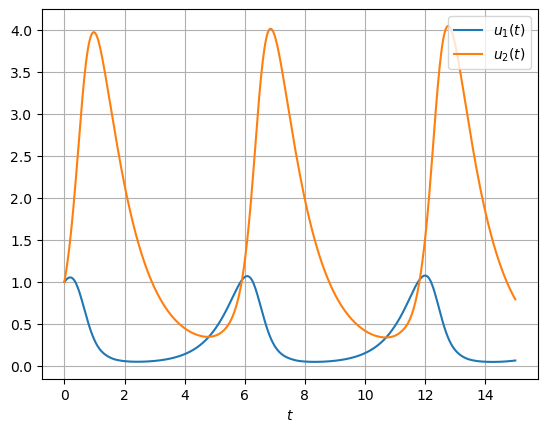

In [5]:
fig, ax = plt.subplots()
u_traj = sol.y

# Plot trajectory that generated data
ax.plot(t_traj, u_traj[0, :], label="$u_1(t)$")
ax.plot(t_traj, u_traj[1, :], label="$u_2(t)$")

ax.legend(loc="best")
ax.set_xlabel("$t$")
ax.grid()

We can see that the populations of the predators and prey oscillate over time
and keep each other in balance. 

Since we are dealing with a 2-dimensional state evolving over time, we can also visualize the trajectory in 3D:

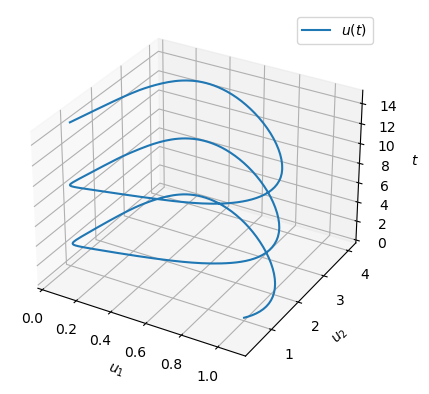

In [6]:
ax = plt.figure().add_subplot(projection="3d")

ax.plot(u_traj[0, :], u_traj[1, :], t_traj, label="$u(t)$")

ax.legend(loc="best")
ax.set_xlabel("$u_1$")
ax.set_ylabel("$u_2$")
ax.set_zlabel("$t$")
ax.grid()

## Implementing ODE solvers
Let's naively implement our own solvers in NumPy, replicating the `solve_ivp` interface.

For this purpose we first introduce an abstract parent class for ODE solvers.
Child classes now only have to implement the `step` function.

In [7]:
from abc import ABC, abstractmethod  # abstract base classes


class ODESolver(ABC):
    @abstractmethod
    def step(self, f, t, u):
        """Apply a single integration step.
        Takes in f, tₖ and uₖ and returns tₖ₊₁, uₖ₊₁.
        """
        pass

    def __call__(self, f, tspan, u0):
        "Solve initial value problem, similar to SciPy's solve_ivp."
        t0, te = tspan
        t = t0
        u = u0

        ts = [t]
        us = [u]
        while t < te:
            t, u = self.step(f, t, u)
            us.append(u)
            ts.append(t)

        us = np.stack(us, axis=-1)
        return us, ts

## Task 1: Forward Euler method (10 P)

Using a constant step size $\Delta t$, a single step of the forward Euler method can be implemented as:
\begin{align*}
    t_{k+1} &= t_k + \Delta t \\
    u_{k+1} &= u_k + \Delta t \cdot  f(t_k, u_k)
\end{align*}



In [18]:
class EulerSolver(ODESolver):

    def __init__(self, dt):
        super().__init__()
        self.dt = dt

    def step(self, f, t, u):
        ## INSERT YOUR SOLUTION HERE
        t_next = t + self.dt
        u_next = u + self.dt * f(t, u)
        ## END YOUR SOLUTION
        return t_next, u_next

Using a step size of `dt=0.01`, we obtain a numerical approximation to the solution of the IVP:

In [20]:
euler = EulerSolver(0.1)
u_euler, t_euler = euler(f_true, tspan, u0)
u_euler

array([[1.00000000e+00, 1.05000000e+00, 1.08150000e+00, 1.08604230e+00,
        1.05506315e+00, 9.82434736e-01, 8.68255635e-01, 7.22335044e-01,
        5.64069061e-01, 4.16182659e-01, 2.95194583e-01, 2.06145355e-01,
        1.45024277e-01, 1.04496023e-01, 7.78289366e-02, 6.01322028e-02,
        4.81987743e-02, 4.00100982e-02, 3.43074579e-02, 3.03007492e-02,
        2.74871643e-02, 2.55416951e-02, 2.42513236e-02, 2.34751681e-02,
        2.31200274e-02, 2.31251498e-02, 2.34526143e-02, 2.40811934e-02,
        2.50024215e-02, 2.62180966e-02, 2.77387372e-02, 2.95826994e-02,
        3.17757657e-02, 3.43510888e-02, 3.73494159e-02, 4.08195500e-02,
        4.48190215e-02, 4.94149587e-02, 5.46851548e-02, 6.07193356e-02,
        6.76206379e-02, 7.55073121e-02, 8.45146645e-02, 9.47972588e-02,
        1.06531393e-01, 1.19917872e-01, 1.35185081e-01, 1.52592369e-01,
        1.72433735e-01, 1.95041774e-01, 2.20791815e-01, 2.50106128e-01,
        2.83457975e-01, 3.21375151e-01, 3.64442434e-01, 4.133020

## Task 2: Runge-Kutta 4 method (20 P)
Let's use a more sophisticated method of integration. The Runge-Kutta methods are a group of IVP solvers, of which the fourth order method is the most widely known.

Using a constant step size $\Delta t$, a single step of the Runge-Kutta 4 method can be implemented as:
\begin{align*}
    t_{k+1} &= t_k + \Delta t\\[0.5em]
    u_{k+1} &= u_k + \frac{\Delta t}{6}(k_1 + 2 k_2 + 2 k_3 + k_4)
\end{align*}
with
\begin{align*}
    k_1 &= f(u_k,\, t_k) \\[0.75em]
    k_2 &= f(u_k + \frac{\Delta t}{2} k_1,\, t_k + \frac{\Delta t}{2}) \\[0.5em]
    k_3 &= f(u_k + \frac{\Delta t}{2} k_2,\, t_k + \frac{\Delta t}{2}) \\[0.7em]
    k_4 &= f(u_k + \Delta t\, k_3,\, t_k + \Delta t) \quad .
\end{align*}

(**Note:** By default, SciPy uses the adaptive step size Runge-Kutta 5(4) method `RK45`.)


In [32]:
class RungeKuttaSolver(ODESolver):

    def __init__(self, dt):
        super().__init__()
        self.dt = dt

    def step(self, f, t, u):
        ## INSERT YOUR SOLUTION HERE
        t_next = t + self.dt
        
        k1 = f( t , u )
        k2 = f( t + self.dt / 2 , u + ( self.dt / 2) * k1 )
        k3 = f( t + self.dt / 2 , u + ( self.dt / 2) * k2 )
        k4 = f( t_next  , u + self.dt * k3 )
        
        u_next = u + ( self.dt / 6 ) * ( k1 + 2 * k2 + 2 * k3 + k4)
        
        #import solution
        #t_next, u_next = solution.task2_step(self.dt, f, t, u)
        ## END YOUR SOLUTION
        return t_next, u_next

In [13]:
rk = RungeKuttaSolver(0.1)
u_rk, t_rk = rk(f_true, tspan, u0)
u_rk

array([[1.        , 1.03980898, 1.0533215 , 1.03247374, 0.9729192 ,
        0.87736197, 0.75667975, 0.62692118, 0.50351596, 0.39661594,
        0.31003662, 0.24297911, 0.19240756, 0.15477759, 0.12690464,
        0.10624433, 0.09088345, 0.07942855, 0.07088052, 0.06452773,
        0.05986422, 0.05653036, 0.05427099, 0.05290613, 0.05231084,
        0.05240111, 0.05312429, 0.05445247, 0.05637794, 0.05891025,
        0.06207439, 0.06590968, 0.07046939, 0.0758208 , 0.0820457 ,
        0.08924112, 0.09752047, 0.10701481, 0.11787433, 0.13026999,
        0.14439517, 0.16046729, 0.17872927, 0.1994505 , 0.22292713,
        0.24948111, 0.27945733, 0.31321781, 0.3511315 , 0.3935575 ,
        0.44081854, 0.49316011, 0.55068896, 0.61328172, 0.68045187,
        0.7511611 , 0.8235619 , 0.89467044, 0.96000492, 1.01330873,
        1.0466304 , 1.05121747, 1.0196935 , 0.94939746, 0.84537633,
        0.72044096, 0.59107844, 0.47156791, 0.37023182, 0.28935119,
        0.22727419, 0.18068759, 0.14609213, 0.12

## Visualization

By plotting the results, we observe that the Runge-Kutta 4 method is much more accurate than the simple forward Euler method, which diverges over time as numerical  errors accumulate.

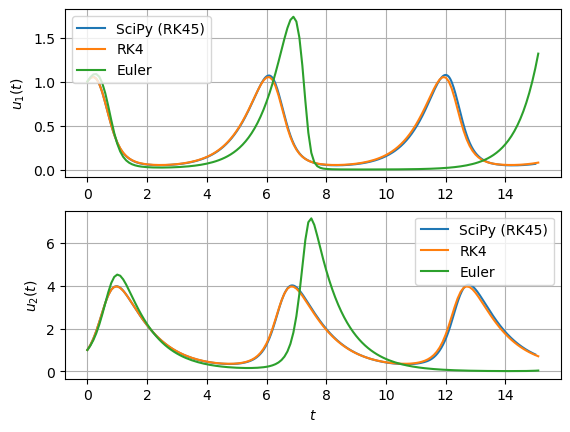

In [39]:
fig, axs = plt.subplots(2, 1)

for i in range(n_states):
    # Plot true trajectory
    axs[i].plot(t_traj, u_traj[i, :], label="SciPy (RK45)")
    # Plot solvers
    axs[i].plot(t_rk, u_rk[i, :], label=r"RK4")
    axs[i].plot(t_euler, u_euler[i, :], label=r"Euler")

    axs[i].set_ylabel(f"$u_{i+1}(t)$")
    axs[i].legend(loc="best")
    axs[i].grid()

axs[n_states - 1].set_xlabel("$t$");

# Exercise 2: Trajectory Optimization
## Dataset generation
Using the dynamics defined in exercise 1, we generate a small dataset of 31 points at equidistant time steps from $t_0=0$ to $t_\text{end}=3$:


In [40]:
te = 3.0
n_data = 31
t_data = np.linspace(t0, te, n_data)

sol_data = solve_ivp(f_true, (t0, te), u0, t_eval=t_data)
u_data = sol_data.y

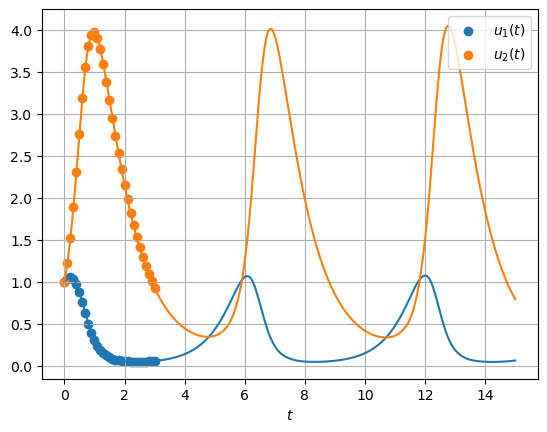

In [41]:
fig, ax = plt.subplots()

# Plot trajectory that generated data
ax.plot(t_traj, u_traj[0, :], c="C0")
ax.plot(t_traj, u_traj[1, :], c="C1")

# Plot data
ax.scatter(t_data, u_data[0, :], c="C0", label="$u_1(t)$")
ax.scatter(t_data, u_data[1, :], c="C1", label="$u_2(t)$")

ax.legend(loc="best")
ax.set_xlabel("$t$")
ax.grid()

## Defining a Neural ODE in torchdiffeq
Using PyTorch, we want to learn the ground truth dynamics $f(t, u)$ that generated our dataset (`u_data`, `t_data`) by fitting a Neural ODE $f_\theta(t, u)$.

To compute gradients of a loss function w.r.t. $\theta$, we import [torchdiffeq](https://github.com/rtqichen/torchdiffeq), which implements the *adjoint method*.
We can construct an adjoint ODE and integrate it backwards in time using the `odeint_adjoint` function.

In [167]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchdiffeq import odeint_adjoint as odeint

# Fix random seed
torch.manual_seed(123)

# Automatically use GPU if CUDA is available
device = torch.device("cuda:" + str(0) if torch.cuda.is_available() else "cpu")

In [168]:
# Convert dataset to Torch tensors
u0_torch = torch.tensor([1.0, 1.0]).to(device)
t_torch = torch.tensor(t_data).to(device)
u_target = torch.tensor(u_data.transpose()).to(device)

We define a small wrapper module that implements a `forward` function $f_\theta(t, u)$. 

In [169]:
class MyNeuralODE(nn.Module):
    def __init__(self, net):
        super().__init__()
        self.net = net  # neural network

    def forward(self, _t, u):
        return self.net(u)

We now need to define a neural network.
Usually, these are kept very small, since they will be repeatedly applied during the integration.

High derivatives $\dot{u}=f_\theta(t, u)$ will quickly make the trajectory diverge toward `inf`.
To make training more stable, we modify the weights and biases to be very small at initialization:

In [170]:
net = nn.Sequential(
    nn.Linear(2, 16),  # input dimensionality of u
    nn.Tanh(),
    nn.Linear(16, 2),  # output dimensionality of u
)

for layer in net.modules():
    if isinstance(layer, nn.Linear):
        nn.init.normal_(layer.weight, mean=0.0, std=0.05)
        nn.init.constant_(layer.bias, val=0.0)

# Define Neural ODE
neural_ode = MyNeuralODE(net).to(device)

Let's integrate the neural ODE and visualize the initialization.

Note that compared to SciPy's `solve_ivp`, the output is transposed (`(n_steps, n_states)` instead of `(n_states, n_steps)`).

In [171]:
u_pred = odeint(neural_ode, u0_torch, t_torch).to(device)
u_pred.size()

torch.Size([31, 2])

Hidden in the following cell are two helper functions `visualize_prediction_2d` and `3d`, plot the current trajectory of the neural ODE. 

In [172]:
def pred_to_numpy(u):
    return u.detach().cpu().numpy().transpose()


def visualize_prediction_2d(neural_ode):
    u_pred = pred_to_numpy(odeint(neural_ode, u0_torch, t_torch))

    # Compute full neural ODE trajectory
    t_full = torch.linspace(t0, te, 501).to(device)
    u_full = pred_to_numpy(odeint(neural_ode, u0_torch, t_full))

    fig, axs = plt.subplots(2, 1)

    for i in range(n_states):
        # Plot data
        axs[i].scatter(t_data, u_data[i, :], c="C0", label="Data")
        # Plot neural ODE prediction
        axs[i].scatter(t_data, u_pred[i, :], c="C1", label="Prediction")
        # Plot full neural ODE trajectory
        axs[i].plot(t_full, u_full[i, :], c="C1")

        axs[i].set_ylabel(f"$u_{i+1}(t)$")
        axs[i].legend(loc="best")
        axs[i].grid()

    axs[n_states - 1].set_xlabel("$t$")


def visualize_prediction_3d(neural_ode):
    u_pred = pred_to_numpy(odeint(neural_ode, u0_torch, t_torch))

    # Compute full neural ODE trajectory
    t_full = torch.linspace(t0, te, 501).to(device)
    u_full = pred_to_numpy(odeint(neural_ode, u0_torch, t_full))

    ax = plt.figure().add_subplot(projection="3d")

    # Plot data
    ax.scatter(u_data[0, :], u_data[1, :], t_data, c="C0", label="Data")
    # Plot neural ODE prediction
    ax.scatter(u_pred[0, :], u_pred[1, :], t_data, c="C1", label="Prediction")
    # Plot full neural ODE trajectory
    ax.plot(u_full[0, :], u_full[1, :], t_full, c="C1")

    ax.legend(loc="best")
    ax.set_xlabel("$u_1$")
    ax.set_ylabel("$u_2$")
    ax.set_zlabel("$t$")
    ax.grid()

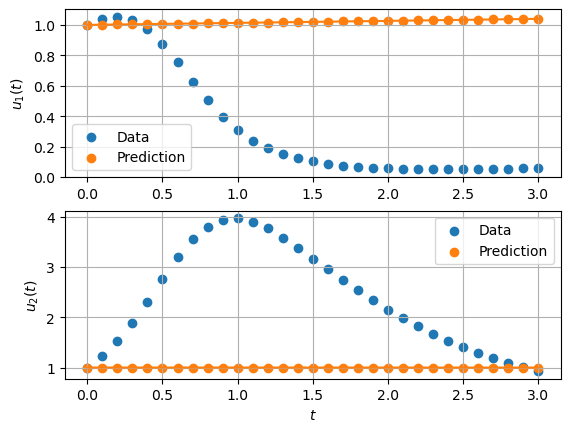

In [173]:
visualize_prediction_2d(neural_ode)

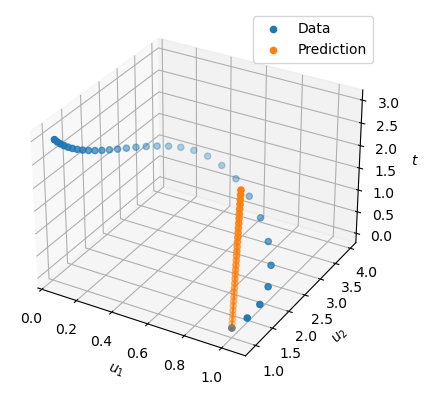

In [174]:
visualize_prediction_3d(neural_ode)

## Task 3: Loss function (10 P)
Implement a loss function `loss_fn(u, u_pred)` that implements

$$ \mathcal{L}(\theta) = \sum\limits_{k=0}^{N} ||u_k - \hat{u}_k||^2 \quad ,$$

where $N$ corresponds to `n_steps`, $u_k$ to the target state vector at time step $k$ 
and $\hat{u}_k$ to the predicted state vector that results from integrating the neural ODE.

You can assume that both `u` and `u_pred` are of shape `(n_steps, n_states)`. Make sure the output is a scalar value.

In [175]:
def loss_fn(u, u_pred):
    ## INSERT YOUR SOLUTION HERE
    loss =  torch.sum((u - u_pred)**2)
    ## END YOUR SOLUTION
    return loss

In [176]:
loss_fn(u_target, u_pred)

tensor(110.0247, dtype=torch.float64, grad_fn=<SumBackward0>)

## Task 4: Training (30 P)
Implement the training loop:
- Compute a prediction using `odeint`.
- Compute the loss using the `loss_fn` from task 3 and `u_target`.
- Compute gradients and apply a step of the optimizer.

**Optional bonus task:** Create an animation of the trajectories during training using `visualize_prediction_2d`/`3d` (or your own plotting function) and save it as a GIF.

In [180]:
torch.manual_seed(123)  # Fix random seed

optimizer = optim.Adam(neural_ode.parameters(), lr=2e-3)

n_iters = 1000
print_every = 50

for i in range(1, n_iters + 1):
    optimizer.zero_grad()

    ## INSERT YOUR SOLUTION HERE
    u_pred = odeint(neural_ode, u0_torch, t_torch) # compute prediction
    loss = loss_fn(u_target, u_pred) # compute loss
    loss.backward() # compute gradients
    optimizer.step() # update optimizer state
    ## END YOUR SOLUTION

    if i == 1 or i % print_every == 0:
        print(f"Step: {i :4d} | Loss: {loss.item() :.6f}")
        # visualize_prediction_2d(neural_ode)

Step:    1 | Loss: 1.025790
Step:   50 | Loss: 0.985709
Step:  100 | Loss: 0.961145
Step:  150 | Loss: 0.946729
Step:  200 | Loss: 0.932235
Step:  250 | Loss: 0.911420
Step:  300 | Loss: 0.878379
Step:  350 | Loss: 0.825362
Step:  400 | Loss: 0.744855
Step:  450 | Loss: 0.636295
Step:  500 | Loss: 0.523412
Step:  550 | Loss: 0.409512
Step:  600 | Loss: 0.316831
Step:  650 | Loss: 0.240536
Step:  700 | Loss: 0.182489
Step:  750 | Loss: 0.136329
Step:  800 | Loss: 0.105156
Step:  850 | Loss: 0.077204
Step:  900 | Loss: 0.059417
Step:  950 | Loss: 0.047272
Step: 1000 | Loss: 0.038223


Let's visualize the resulting fit:

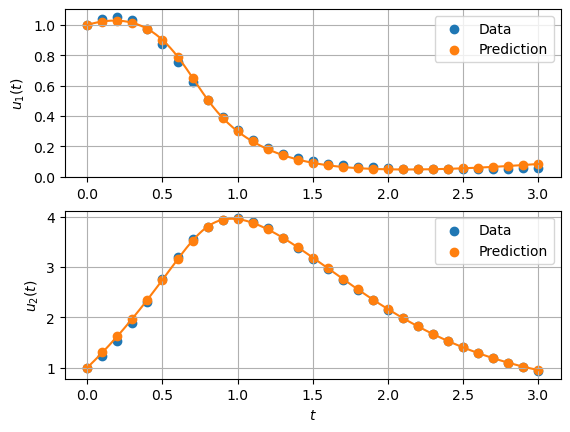

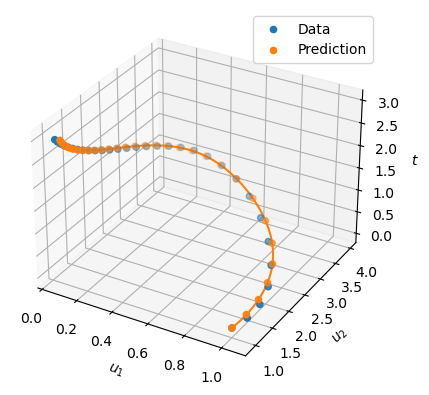

In [181]:
visualize_prediction_2d(neural_ode)
visualize_prediction_3d(neural_ode)

Since our neural ODE hasn't fully converged yet, you can increase `n_iters`, tweak the learning rate and re-train to obtain a better prediction.

We could now use the trained neural network as a surrogate model.
For example, as shown in the lecture, we could apply symbolic regression to recover the Lotka-Volterra equations.